# Dataset curation - Feature scaling for time series data

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/ai-nose/blob/master/ai-nose-dataset-curation.ipynb)

In the paper "Efficient BackProp" [1], LeCun et al. shows that we can achieve a more accurate model (e.g. artificial neural network) in less time by standarizing (i.e. to a mean of 0 and unit variance) and decorrelating our input data.

However, the process of standarization assumes that the data is normally distributed (i.e. Gaussian). If our data does not follow a Gaussian distribution, we should perform normalization [2], where we divide by the range to produce a set of values between 0 and 1.

Create a directory */content/dataset* and upload your entire dataset there. Run through the cells in this notebook, following all of the directions to analyze the data and create a curated dataset. If you perform normalization or standarization for any dimension, you will need to copy the mean, standard deviation, minimum, and range arrays for use in your inference code (i.e. preprocessing the data before running inference).

[1] http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

[2] https://becominghuman.ai/what-does-feature-scaling-mean-when-to-normalize-data-and-when-to-standardize-data-c3de654405ed 

## Step 1: Analyze the data

In [1]:
import csv
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
### Settings
HOME_PATH = "/content"              # Location of the working directory
DATASET_PATH = "/content/dataset"   # Upload your .csv samples to this directory
OUT_PATH = "/content/out"           # Where output files go (will be deleted and recreated)
OUT_ZIP = "/content/out.zip"        # Where to store the zipped output files

# Do not change these settings!
PREP_DROP = -1                      # Drop a column
PREP_NONE = 0                       # Perform no preprocessing on column of data
PREP_STD = 1                        # Perform standardization on column of data
PREP_NORM = 2                       # Perform normalization on column of data

In [3]:
### Read in .csv files to construct one long multi-axis, time series data

# Store header, raw data, and number of lines found in each .csv file
header = None
raw_data = []
num_lines = []
filenames = []

# Read each CSV file
for filename in os.listdir(DATASET_PATH):

  # Check if the path is a file
  filepath = os.path.join(DATASET_PATH, filename)
  if not os.path.isfile(filepath):
    continue

  # Read the .csv file
  with open(filepath) as f:
    csv_reader = csv.reader(f, delimiter=',')

    # Read each line
    valid_line_counter = 0
    for line_count, line in enumerate(csv_reader):

      # Check header
      if line_count == 0:

        # Record first header as our official header for all the data
        if header == None:
          header = line

        # Check to make sure subsequent headers match the original header
        if header == line:
          num_lines.append(0)
          filenames.append(filename)
        else:
          print("Error: Headers do not match. Skipping", filename)
          break

      # Construct raw data array, make sure number of elements match number of header labels
      else:
        if len(line) == len(header):
          raw_data.append(line)
          num_lines[-1] += 1
        else:
          print("Error: Data length does not match header length. Skipping line.")
          continue

# Convert our raw data into a numpy array
raw_data = np.array(raw_data).astype(float)

# Print out our results
print("Dataset array shape:", raw_data.shape)
print("Number of elements in num_lines:", len(num_lines))
print("Number of filenames:", len(filenames))
assert(len(num_lines) == len(filenames))

Dataset array shape: (8416, 10)
Number of elements in num_lines: 1052
Number of filenames: 1052


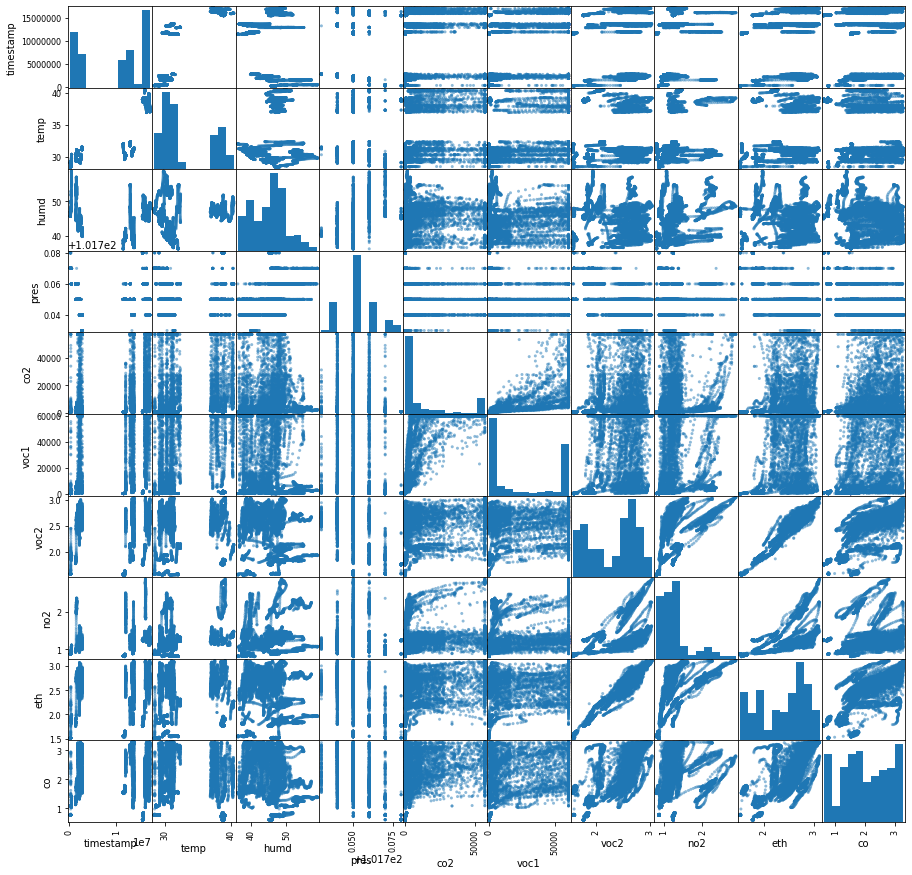

In [4]:
### Plot scatter matrix to look for correlation

# Convert NumPy array to Pandas DataFrame
df = pd.DataFrame(raw_data, columns=header)

# Create scatter matrix
sm = pd.plotting.scatter_matrix(df, figsize=(15, 15))

Notice the wide range of input values! We need to get those to be close to the same range so that the correlation plots will make more sense. Before we do that, we should plot the histograms to see how the data is distributed.

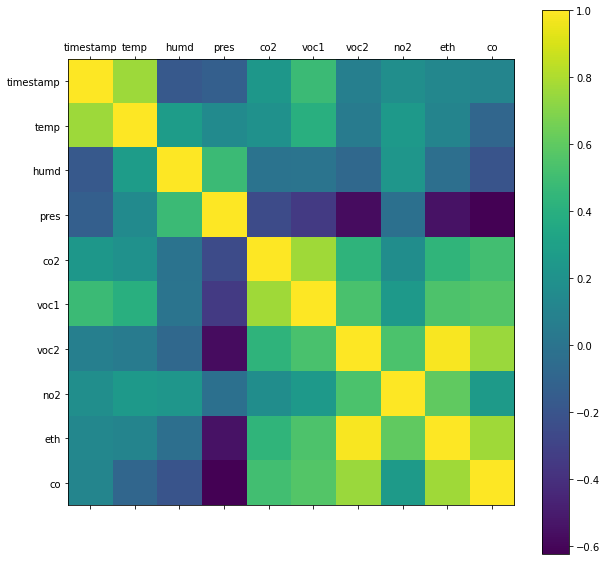

In [5]:
### Show correlation matrix as colors

# Create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(df.corr())

# Add legend
fig.colorbar(im)

# Add x and y labels
_ = ax.set_xticks(np.arange(len(header)))
_ = ax.set_xticklabels(header)
_ = ax.set_yticks(np.arange(len(header)))
_ = ax.set_yticklabels(header)

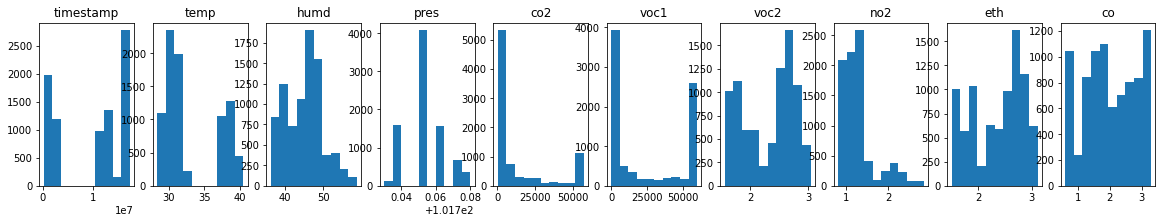

In [6]:
### Examine the histograms of all the data

# Create subplots
num_hists = len(header)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(raw_data[:, i])
  axs[i].title.set_text(header[i])

In [7]:
### Analyze the data

# Calculate means, standard deviations, and ranges
means = np.mean(raw_data, axis=0)
std_devs = np.std(raw_data, axis=0)
maxes = np.max(raw_data, axis=0)
mins = np.min(raw_data, axis=0)
ranges = np.ptp(raw_data, axis=0)

# Print results
for i, name in enumerate(header):
  print(name)
  print("  mean:", means[i])
  print("  std dev:", std_devs[i])
  print("  max:", maxes[i])
  print("  min:", mins[i])
  print("  range:", ranges[i])

timestamp
  mean: 9735267.00380228
  std dev: 6494581.301430915
  max: 17132068.0
  min: 234236.0
  range: 16897832.0
temp
  mean: 33.06718274714824
  std dev: 3.942326230810903
  max: 40.47
  min: 28.35
  range: 12.119999999999997
humd
  mean: 45.05665755703447
  std dev: 4.785831608212135
  max: 58.79
  min: 36.17
  range: 22.619999999999997
pres
  mean: 101.75259030418394
  std dev: 0.010436819744125672
  max: 101.78
  min: 101.73
  range: 0.04999999999999716
co2
  mean: 13167.196173954373
  std dev: 19695.79504930389
  max: 57330.0
  min: 400.0
  range: 56930.0
voc1
  mean: 24793.667181558936
  std dev: 26184.58808047209
  max: 60000.0
  min: 0.0
  range: 60000.0
voc2
  mean: 2.3147278992395774
  std dev: 0.44526319502436573
  max: 3.04
  min: 1.56
  range: 1.48
no2
  mean: 1.2779253802281139
  std dev: 0.4007439874549899
  max: 2.86
  min: 0.81
  range: 2.05
eth
  mean: 2.3569130228136816
  std dev: 0.47381624063284383
  max: 3.11
  min: 1.51
  range: 1.5999999999999999
co
  mean:

## Step 2: Choose how to preprocess the data

In [8]:
### Choose preprocessing method for each column
#     PREP_DROP: Drop column
#     PREP_NONE: no preprocessing
#     PREP_STD: standardization (if data is Gaussian)
#     PREP_NORM: normalization (if data is non-Gaussian)

# Change this to match your picks!
preproc = [PREP_NONE,   # Timestamp
           PREP_NORM,   # Temperature
           PREP_NORM,   # Humidity
           PREP_DROP,   # Pressure
           PREP_NORM,   # CO2
           PREP_NORM,   # VOC1
           PREP_NORM,   # VOC2
           PREP_NORM,   # NO2
           PREP_NORM,   # Ethanol
           PREP_NORM]   # CO

# Check to make sure we have the correct number of preprocessing request elements
assert(len(preproc) == len(header))
assert(len(preproc) == raw_data.shape[1])

# ### If we do not need the timestamp column, drop it from the data
# if not KEEP_TIMESTAMP:
#   header = header[1:]
#   raw_data = raw_data[:,1:]
#   print("Array shape without timestamp:", data_without_time.shape)

## Step 3: Perform data preprocessing

In [9]:
### Perform preprocessing steps as requested

# Figure out how many columns we plan to keep
num_cols = sum(1 for x in preproc if x != PREP_DROP)

# Create empty numpy array and header for preprocessed data
prep_data = np.zeros((raw_data.shape[0], num_cols))
prep_header = []
prep_means = []
prep_std_devs = []
prep_mins = []
prep_ranges = []

# Go through each column to preprocess the data
prep_c = 0
for raw_c in range(len(header)):

  # Drop column if requested
  if preproc[raw_c] == PREP_DROP:
    print("Dropping", header[raw_c])
    continue

  # Perform data standardization
  if preproc[raw_c] == PREP_STD:
    prep_data[:, prep_c] = (raw_data[:, raw_c] - means[raw_c]) / std_devs[raw_c]

  # Perform data normalization
  elif preproc[raw_c] == PREP_NORM:
    prep_data[:, prep_c] = (raw_data[:, raw_c] - mins[raw_c]) / ranges[raw_c]

  # Copy data over if no preprocessing is requested
  elif preproc[raw_c] == PREP_NONE:
    prep_data[:, raw_c] = raw_data[:, raw_c]

  # Error if code not recognized
  else:
    raise Exception("Preprocessing code not recognized")

  # Copy header (and preprocessing constants) and increment preprocessing column index
  prep_header.append(header[raw_c])
  prep_means.append(means[raw_c])
  prep_std_devs.append(std_devs[raw_c])
  prep_mins.append(mins[raw_c])
  prep_ranges.append(ranges[raw_c])
  prep_c += 1

# Show new data header and shape
print(prep_header)
print("New data shape:", prep_data.shape)
print("Means:", [float("{:.4f}".format(x)) for x in prep_means])
print("Std devs:", [float("{:.4f}".format(x)) for x in prep_std_devs])
print("Mins:", [float("{:.4f}".format(x)) for x in prep_mins])
print("Ranges:", [float("{:.4f}".format(x)) for x in prep_ranges])

Dropping pres
['timestamp', 'temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co']
New data shape: (8416, 9)
Means: [9735267.0038, 33.0672, 45.0567, 13167.1962, 24793.6672, 2.3147, 1.2779, 2.3569, 2.016]
Std devs: [6494581.3014, 3.9423, 4.7858, 19695.795, 26184.5881, 0.4453, 0.4007, 0.4738, 0.7975]
Mins: [234236.0, 28.35, 36.17, 400.0, 0.0, 1.56, 0.81, 1.51, 0.61]
Ranges: [16897832.0, 12.12, 22.62, 56930.0, 60000.0, 1.48, 2.05, 1.6, 2.68]


## Step 4: Analyze newly preprocessed data

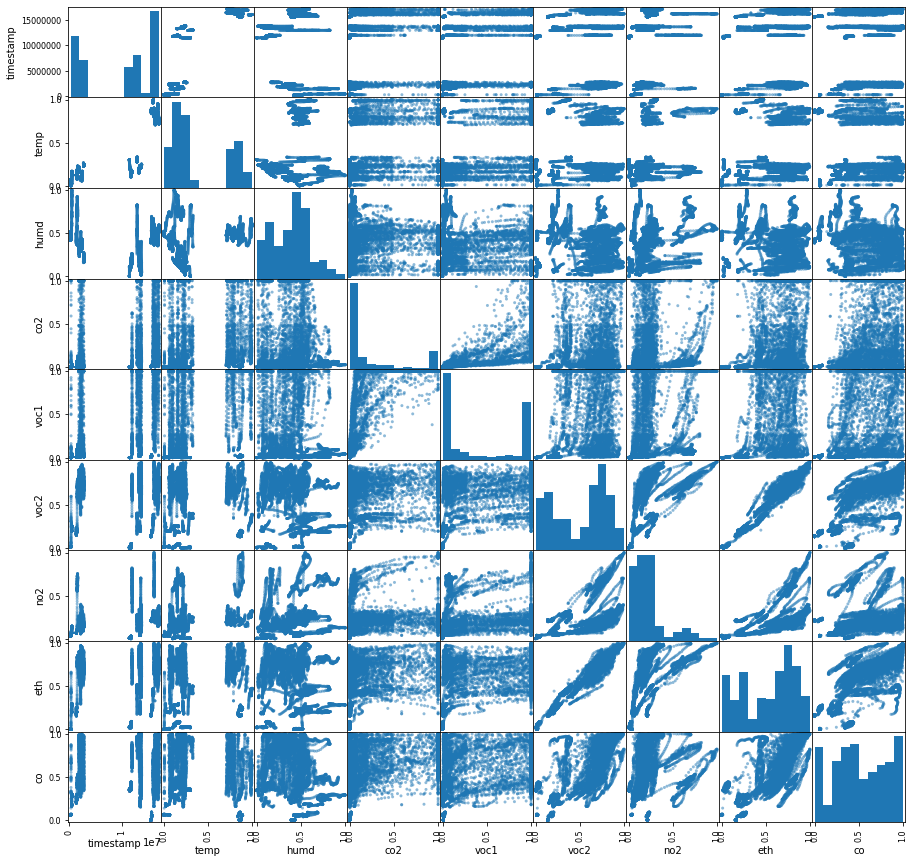

In [10]:
### Recreate the scatter matrix to look for correlation

# Convert NumPy array to Pandas DataFrame
df = pd.DataFrame(prep_data, columns=prep_header)

# Create scatter matrix
sm = pd.plotting.scatter_matrix(df, figsize=(15, 15))

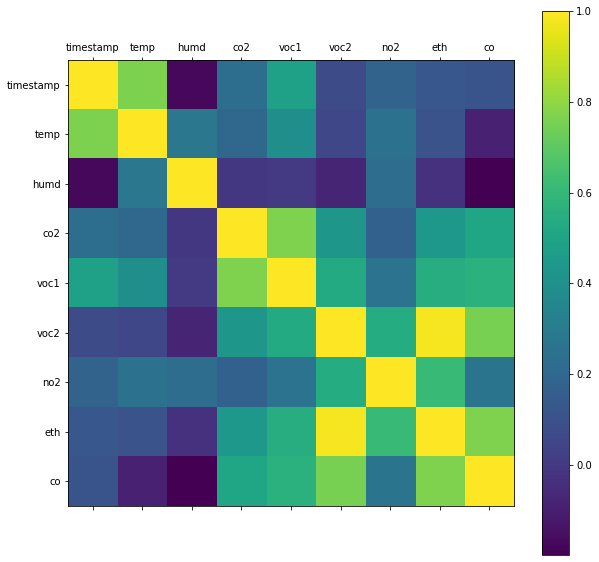

In [11]:
### Show correlation matrix as colors

# Create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(df.corr())

# Add legend
fig.colorbar(im)

# Add x and y labels
_ = ax.set_xticks(np.arange(len(prep_header)))
_ = ax.set_xticklabels(prep_header)
_ = ax.set_yticks(np.arange(len(prep_header)))
_ = ax.set_yticklabels(prep_header)

## Step 5: Store preprocessed data in CSV files

In [12]:
### Delete output directory (if it exists) and recreate it
if os.path.exists(OUT_PATH):
  shutil.rmtree(OUT_PATH)
os.makedirs(OUT_PATH)

In [13]:
### Write out data to .csv files

# Go through all the original filenames
row_index = 0
for file_num, filename in enumerate(filenames):

  # Open .csv file
  file_path = os.path.join(OUT_PATH, filename)
  with open(file_path, 'w') as f:
    csv_writer = csv.writer(f, delimiter=',')

    # Write header
    csv_writer.writerow(prep_header)

    # Write contents
    for _ in range(num_lines[file_num]):
      csv_writer.writerow(prep_data[row_index])
      row_index += 1

In [14]:
### Zip output directory
%cd {OUT_PATH}
!zip -FS -r -q {OUT_ZIP} *
%cd {HOME_PATH}

/content/out
/content
